# DQN - EXPERIMENT RESULTS REPORT FOR ASTERIX
## This notebook presents the results to COMPER-V5 training runs with this setup:

- Frames mode: staked (84x84x4)
- Total frames: 100,000
- Epsilon decay: from 1 to 0.001 at 90,000 frames
- Color average: yes
- Skip frames: 5
- Stick actions: 0.25

In [43]:
import matplotlib.pyplot as plt
import pandas as pd
import json
import os
import seaborn as sns
from numpy import median
import numpy as np
%matplotlib inline

### LOAD DATA

#### Load all log files

In [44]:
df = pd.DataFrame()
for i in range(1,6):
  aux = pd.read_json('logs/dqn-battle_zone-'+str(i)+'/progress.json',lines=True)
  aux["Trial"] = i
  df=  df.append(aux)
df = df.set_index(["Trial"])
print(df.shape)
df.head()

(26299, 15)


,Train,log_count,iteration,date-time,rom,method,total_frame,episodes,EndEp,frames_episode,episode_reward,total_reward,buffer_len,loss,epsilon
Trial,,,,,,,,,,,,,,,
1,1,0,0,07/13/21 20:19:19,battle_zone,dqn,40,1,False,40,0,0,1,0.0,0.9998
1,1,1,1,07/13/21 20:19:19,battle_zone,dqn,60,1,False,60,0,0,2,0.0,0.9996
1,1,1,2,07/13/21 20:19:19,battle_zone,dqn,80,1,False,80,0,0,3,0.0,0.9994
1,1,1,3,07/13/21 20:19:19,battle_zone,dqn,100,1,False,100,0,0,4,0.0,0.9992
1,1,1,4,07/13/21 20:19:19,battle_zone,dqn,120,1,False,120,0,0,5,0.0,0.9990


In [45]:
df.tail()

,Train,log_count,iteration,date-time,rom,method,total_frame,episodes,EndEp,frames_episode,episode_reward,total_reward,buffer_len,loss,epsilon
Trial,,,,,,,,,,,,,,,
5,1,92,5132,07/13/21 22:37:58,battle_zone,dqn,102812,21,False,4580,0,23000,5133,0.001249,0.01
5,1,92,5133,07/13/21 22:37:58,battle_zone,dqn,102832,21,False,4600,0,23000,5134,0.001249,0.01
5,1,92,5134,07/13/21 22:37:58,battle_zone,dqn,102852,21,False,4620,0,23000,5135,0.001249,0.01
5,1,92,5135,07/13/21 22:37:58,battle_zone,dqn,102872,21,False,4640,0,23000,5136,0.001249,0.01
5,1,92,5136,07/13/21 22:37:58,battle_zone,dqn,102891,21,True,4659,0,23000,5137,0.000398,0.01


In [46]:
#Check number of episodes to define the avarages windows sizes
n_trials = len(df.reset_index()["Trial"].unique())
print(n_trials)
n_episodes = len(df["episodes"].unique())
print(n_episodes)
LAST_EPISODES = 3 if n_episodes<25 else 5
LAST_EPISODES_PER_TRIAL = 3 if n_episodes<25 else 10
MOVING_AVG_WINDOWS_SIZE = 3 if n_episodes<25 else 10

5
21


#### Plot log informations 

In [47]:
#df.head(3)

In [48]:
#df.tail(3)

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26299 entries, 1 to 5
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Train           26299 non-null  int64  
 1   log_count       26299 non-null  int64  
 2   iteration       26299 non-null  int64  
 3   date-time       26299 non-null  object 
 4   rom             26299 non-null  object 
 5   method          26299 non-null  object 
 6   total_frame     26299 non-null  int64  
 7   episodes        26299 non-null  int64  
 8   EndEp           26299 non-null  bool   
 9   frames_episode  26299 non-null  int64  
 10  episode_reward  26299 non-null  int64  
 11  total_reward    26299 non-null  int64  
 12  buffer_len      26299 non-null  int64  
 13  loss            26299 non-null  float64
 14  epsilon         26299 non-null  float64
dtypes: bool(1), float64(2), int64(9), object(3)
memory usage: 3.0+ MB


## CHARTS

In [50]:
#Get only the final of each episod
df_1 = df.reset_index()
df_1 = df_1[(df_1["EndEp"] == True)]
df_1 = df_1.set_index(["Trial"])

#Calc the moving average over the episodes per trial
df_ma = df_1.loc[1]["episode_reward"].rolling(window=MOVING_AVG_WINDOWS_SIZE).mean()#média móvel 
df_ma = df_ma.to_frame()
df_ma.dropna(inplace=True)
df_ma['Counter'] = range(len(df_ma))
for i in range(2,6):
    aux = df_1.loc[i]["episode_reward"].rolling(window=MOVING_AVG_WINDOWS_SIZE).mean()   
    aux = aux.to_frame()    
    aux.dropna(inplace=True)    
    aux['Counter'] = range(len(aux))
    df_ma = df_ma.append(aux)


#Calc min. and max. reward per trial
min_max_mean = pd.DataFrame(index=['1', '2', '3', '4', '5'], columns=['min', 'max', 'mean'])
for i in range(0,5):
    min_max_mean.iloc[i]['min'] = df_1.loc[(i+1)]["episode_reward"].min()
    min_max_mean.iloc[i]['max'] =  df_1.loc[(i+1)]["episode_reward"].max()
    min_max_mean.iloc[i]['mean'] = df_1.loc[(i+1)]["episode_reward"].mean()

#Calc each tertile scores average and the last episodes score average per tertile per trial
trials = df_1.reset_index()
trials_n = trials["Trial"].unique()
tirtle_avg = pd.DataFrame()
tritle_last_ep_avg = pd.DataFrame()
for i in trials_n:
    trial=trials.loc[trials['Trial'] == i]
    trial_rews = trial["episode_reward"].to_numpy()
    tertiles = np.array_split(trial_rews,3)    
    tirtle_avg = tirtle_avg.append({"Trial":i,"Tirtle1":np.mean(tertiles[0]),"Tirtle2": np.mean(tertiles[1]),"Tirtle3":np.mean(tertiles[2])},ignore_index=True)
    tritle_last_ep_avg = tritle_last_ep_avg.append(
        {"Trial":i,
        "Tirtle1":np.mean(np.array(tertiles[0])[-LAST_EPISODES:]),
        "Tirtle2": np.mean(np.array(tertiles[1])[-LAST_EPISODES:]),
        "Tirtle3":np.mean(np.array(tertiles[2])[-LAST_EPISODES:])},ignore_index=True)
tirtle_avg = tirtle_avg.set_index(["Trial"])
tritle_last_ep_avg = tritle_last_ep_avg.set_index(["Trial"])

#Cal the average for the last episodes per trial
df_last_mean = pd.DataFrame(index=['1', '2', '3', '4', '5'],columns=['Mean'] )
for i in range (0,5):
    df_last_mean.iloc[i]['Mean'] = df_1.loc[i+1]["episode_reward"][(-LAST_EPISODES_PER_TRIAL):].mean()

[Text(0.5, 1.0, 'Episode reward moving average')]

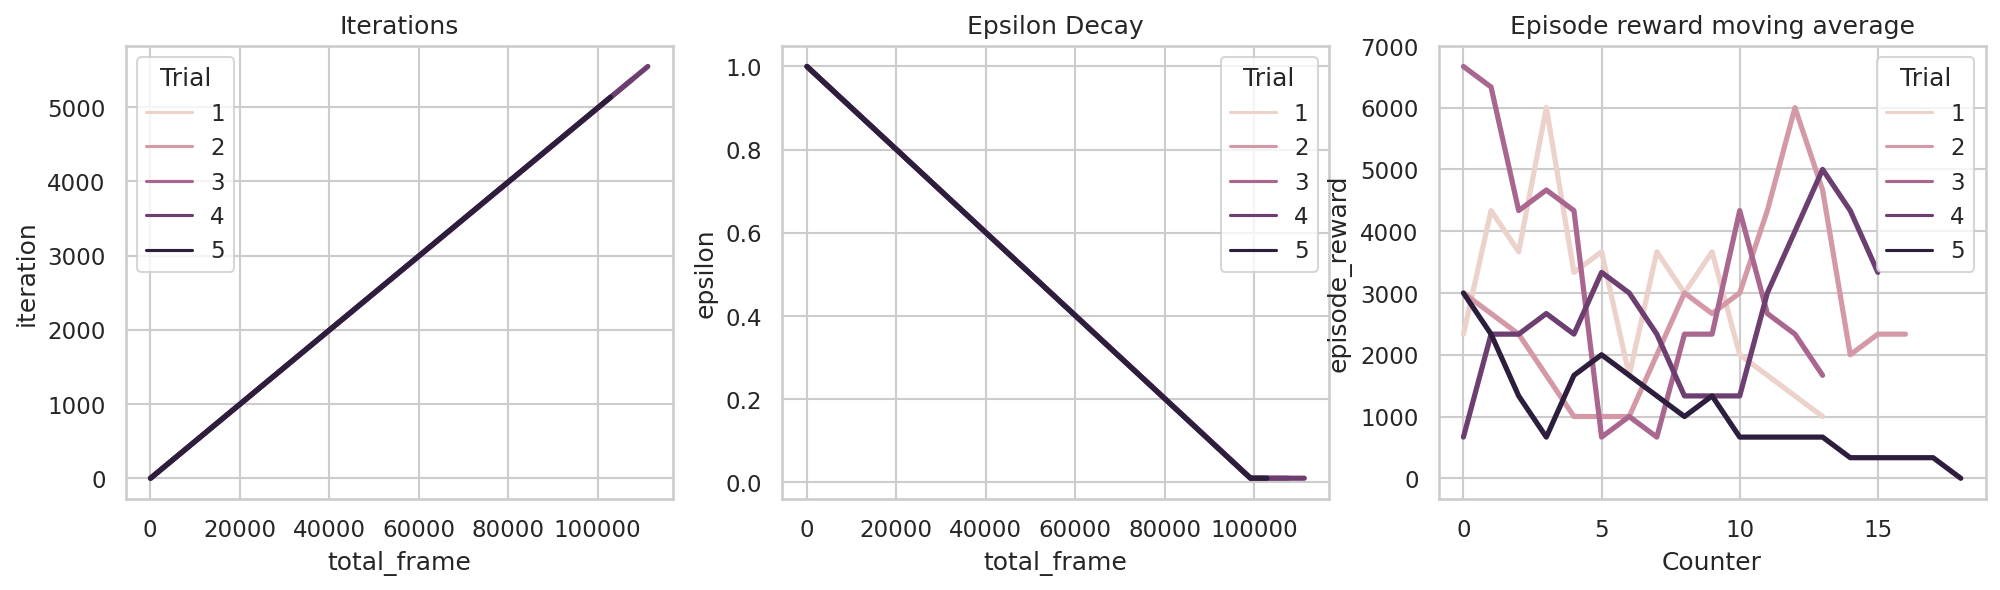

In [51]:
fig, axs = plt.subplots(ncols=3)
fig.set_figwidth(16)
fig.set_dpi(150)
sns.set_theme(style="whitegrid")#, palette="pastel")
sns.lineplot(data=df, x="total_frame", y="iteration", hue="Trial", linewidth=2.5,ax=axs[0]).set(title= "Iterations")
sns.lineplot(data=df, x="total_frame", y="epsilon", hue="Trial", linewidth=2.5,ax=axs[1]).set(title= "Epsilon Decay")
sns.lineplot(data=df_ma, x="Counter", y="episode_reward", hue="Trial", linewidth=2.5,ax=axs[2]).set(title= "Episode reward moving average")

[Text(0.5, 1.0, 'Max reward per trial'), Text(0.5, 0, 'Trials')]

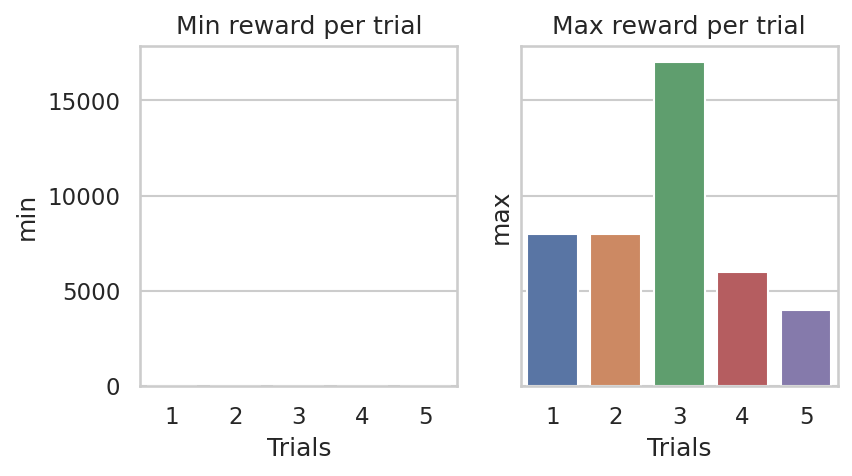

In [52]:
fig, axs = plt.subplots(ncols=2, sharex=True, sharey=True)
fig.set_figheight(3)
fig.set_dpi(150)
sns.barplot(data=min_max_mean, x=min_max_mean.index ,y='min', ax=axs[0]).set(title= "Min reward per trial", xlabel = 'Trials')
sns.barplot(data=min_max_mean, x=min_max_mean.index ,y='max', ax=axs[1]).set(title= "Max reward per trial", xlabel = 'Trials')

[Text(0.5, 1.0, 'Last 3 Episodes Avg.'), Text(0.5, 0, '5 Trials')]

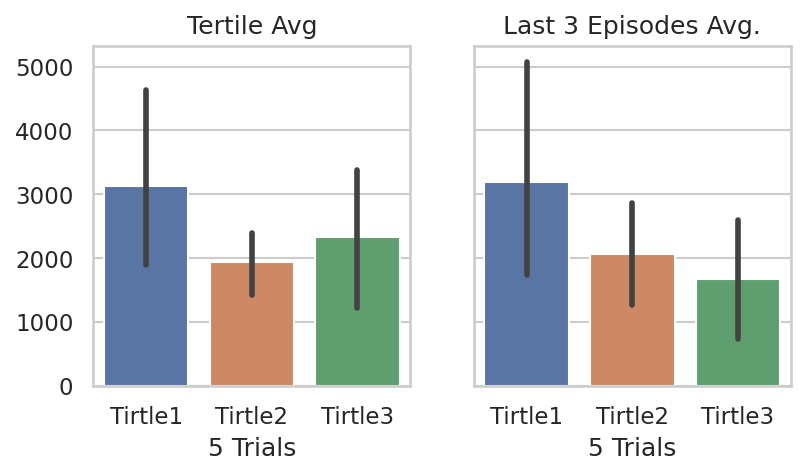

In [53]:
fig, axs = plt.subplots(ncols=2, sharex=True, sharey=True)
fig.set_figheight(3)
fig.set_dpi(150)
sns.barplot(data=tirtle_avg,ax=axs[0]).set(title= "Tertile Avg", xlabel = '5 Trials')
sns.barplot(data=tritle_last_ep_avg,ax=axs[1]).set(title= 'Last ' +str(LAST_EPISODES)+' Episodes Avg.', xlabel = '5 Trials')  

[Text(0.5, 1.0, 'Average reward of the last 3 episodes'),
 Text(0.5, 0, 'Trials')]

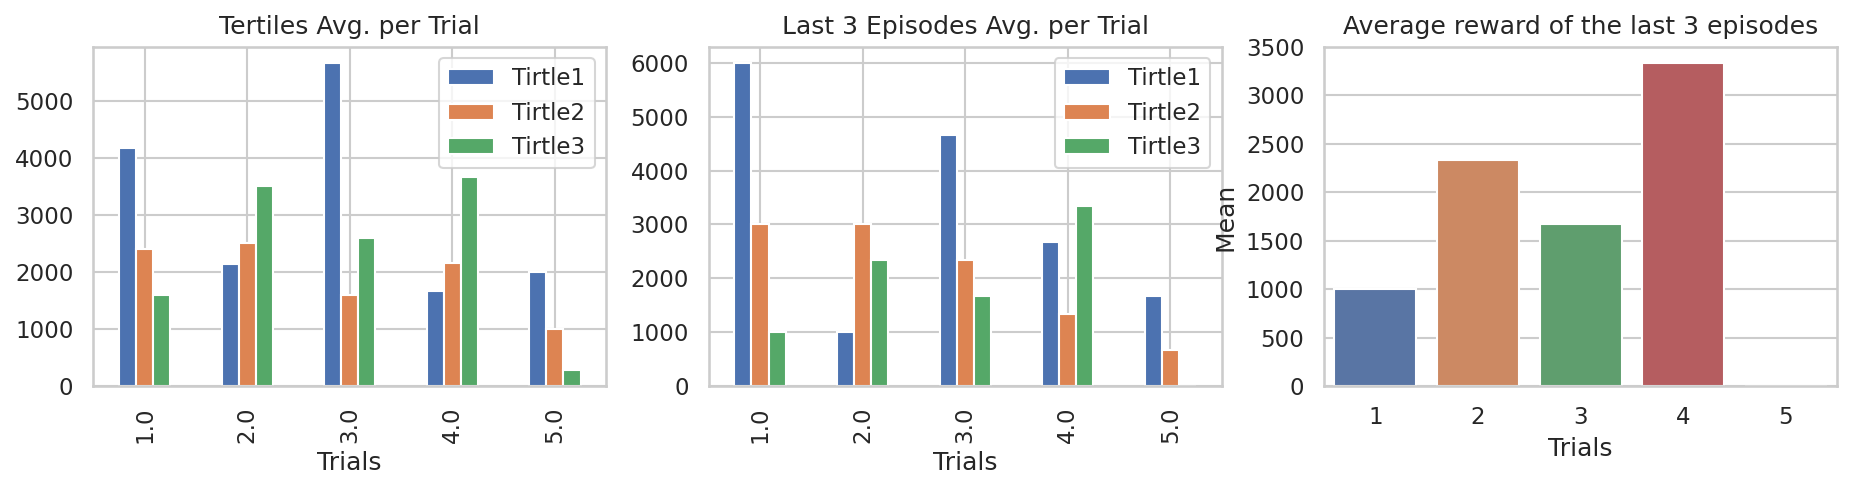

In [54]:
fig, axs = plt.subplots(ncols=3)
fig.set_figwidth(15)
fig.set_figheight(3)
fig.set_dpi(150)
tirtle_avg.plot(kind="bar",ax=axs[0]).set(title= 'Tertiles Avg. per Trial', xlabel = 'Trials')
tritle_last_ep_avg.plot(kind="bar",ax = axs[1]).set(title= 'Last ' +str(LAST_EPISODES)+' Episodes Avg. per Trial', xlabel = 'Trials')
sns.barplot(data=df_last_mean, x=df_last_mean.index,y='Mean',ax=axs[2]).set(title= 'Average reward of the last ' +str(LAST_EPISODES_PER_TRIAL)+ ' episodes', xlabel = 'Trials')

In [55]:
df_t = df_last_mean.transpose()
mean_ = np.mean(df_t[['1','2','3','4','5']].to_numpy())
std = np.std(df_t[['1','2','3','4','5']].to_numpy()).round(decimals=2)
df_t['mean'] = mean_
df_t['std'] = std
df_t

,1,2,3,4,5,mean,std
Mean,1000.0,2333.333333,1666.666667,3333.333333,0.0,1666.666667,1135.29


In [56]:
tritle_last_ep_avg
print(tritle_last_ep_avg)
df_t = pd.DataFrame(tritle_last_ep_avg)
print(pd.DataFrame(tritle_last_ep_avg.mean(axis=0)))
print(pd.DataFrame(tritle_last_ep_avg.std(axis=0)))

           Tirtle1      Tirtle2      Tirtle3
Trial                                       
1.0    6000.000000  3000.000000  1000.000000
2.0    1000.000000  3000.000000  2333.333333
3.0    4666.666667  2333.333333  1666.666667
4.0    2666.666667  1333.333333  3333.333333
5.0    1666.666667   666.666667     0.000000
                   0
Tirtle1  3200.000000
Tirtle2  2066.666667
Tirtle3  1666.666667
                   0
Tirtle1  2089.657069
Tirtle2  1038.160767
Tirtle3  1269.295518
